In [ ]:
学习目标:
- 组建新的合成特征;
- 祛除离群值

## 加载依赖库和数据集

In [2]:
import math
from IPython import display
from matplotlib import cm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn.metrics as metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv('/Users/meininghang/Downloads/california_housing_test.csv')
california_housing_dataframe = california_housing_dataframe.reindex(np.random.permutation(california_housing_dataframe.index))                                          
california_housing_dataframe['median_house_value'] /= 1000.0
california_housing_dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
2322,-123.2,39.1,33.0,1320.0,303.0,1048.0,303.0,1.8,94.7
1503,-121.3,38.8,47.0,2901.0,631.0,1276.0,578.0,2.1,101.9
348,-118.5,34.2,21.0,2692.0,477.0,1330.0,456.0,4.5,238.9
1696,-119.0,35.4,40.0,1912.0,439.0,1015.0,413.0,1.5,52.6
1846,-120.4,35.0,38.0,3004.0,794.0,2601.0,747.0,2.3,106.4
...,...,...,...,...,...,...,...,...,...
694,-122.1,37.0,15.0,3385.0,669.0,1571.0,615.0,4.2,320.9
170,-118.3,33.9,30.0,1764.0,397.0,1406.0,362.0,1.4,93.1
1005,-117.2,33.1,4.0,1862.0,291.0,685.0,248.0,7.7,237.4
765,-119.5,35.1,19.0,4190.0,690.0,1973.0,702.0,4.0,88.3


## 设置输入函数

In [6]:
def my_input_fn(features,targets,batch_size=1,shuffle=True,num_epochs=None):
    #数据类型
    features = {key:np.array(value) for key,value in dict(features).items()}
    #数据集,数据尺寸和重复
    ds = Dataset.from_tensor_slices((features,targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    #置乱
    if shuffle:
        ds = ds.shuffle(buffer_size=10000)
    #返回下个训练集
    features,labels = ds.make_one_shot_iterator().get_next()
    return features,labels
        

## 训练模型

In [12]:
def train_model(learning_rate,steps,batch_size,input_feature):
    periods = 10
    steps_per_period = steps / periods
    
    my_feature = input_feature
    my_feature_data = california_housing_dataframe[[my_feature]].astype('float32')
    my_label = 'median_house_value'
    targets = california_housing_dataframe[my_label].astype('float32')
    
    #输入函数
    training_input_fn = lambda: my_input_fn(my_feature_data,targets,batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(my_feature_data,
                                    targets,num_epochs=1,shuffle=False)
    #特征列
    feature_columns = [tf.feature_column.numeric_column(my_feature)]
    #线性回归对象
    my_optimizer = tf.train.GradientDescentOptimizer(
        learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer,5.0)
    linear_regressor = tf.estimator.LinearRegressor(
        feature_columns=feature_columns,optimizer=my_optimizer)
    #画出每个时段的状态线
    plt.figure(figsize=(15,6))
    plt.subplot(1,2,1)
    plt.title('Linear Line by Period')
    plt.ylabel(my_label)
    plt.xlabel(my_feature)
    sample = california_housing_dataframe.sample(n=300)
    plt.scatter(sample[my_feature],sample[my_label])
    colors = [cm.coolwarm(x) for x in np.linspace(-1,1,periods)]                                                               
    
    #训练模型并输出loss
    print('Training model...')
    print('RMSE(on training data):')
    root_mean_squared_errors = []
    for period in range (0,periods):
        #训练模型
        linear_regressor.train(input_fn=training_input_fn,steps=steps_per_period)
        predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
        predictions = np.array([item['predictions'][0] for item in predictions])
        
        #loss
        root_mean_squared_error = math.sqrt(metrics.mean_squared_error(predictions,targets))
        print('  period %02d : %0.2f' % (period,root_mean_squared_error))
        #list
        root_mean_squared_errors.append(root_mean_squared_error)
        #权重和偏差
        y_extents = np.array([0,sample[my_label].max()])
        weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
        bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')
        
        x_extents = (y_extents - bias) / weight
        x_extents = np.maximum(np.minimum(x_extents,sample[my_feature].max()),sample[my_feature].min())
        y_extents = weight * x_extents + bias
        plt.plot(x_extents,y_extents,color=colors[period])
    print('Model training finished')
    #输出每个时期的loss
    plt.subplot(1,2,2)
    plt.ylabel('RMSE')
    plt.xlabel('Periods')
    plt.title('Root Mean Squared Error vs. Periods')
    plt.tight_layout()
    plt.plot(root_mean_squared_errors)
    
    #统计信息表
    calibration_data = pd.DataFrame()
    calibration_data['targets'] = pd.Series(targets)
    calibration_data['predictions'] = pd.Series(predictions)
    display.display(calibration_data.describe())
    
    print('Final RMSE(on training data):%0.2f' % root_mean_squared_error)
    
    return calibration_data
          

### 合成特征

- 原特征:total_rooms /population
- 新特征:rooms_per_person = total_rooms / populations

Training model...
RMSE(on training data):
  period 00 : 210.14
  period 01 : 187.06
  period 02 : 167.29
  period 03 : 150.65
  period 04 : 138.15
  period 05 : 130.44
  period 06 : 127.35
  period 07 : 125.92
  period 08 : 126.04
  period 09 : 126.46
Model training finished


,targets,predictions
count,3000.0,3000.0
mean,205.8,195.1
std,113.1,84.0
min,22.5,47.7
25%,121.2,160.5
50%,177.7,191.8
75%,264.0,220.2
max,500.0,2629.4


Final RMSE(on training data):126.46


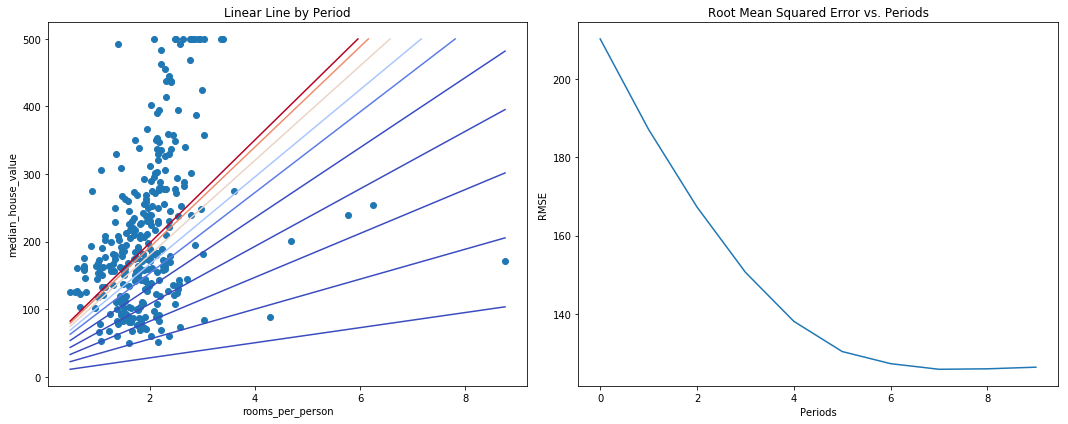

In [13]:
california_housing_dataframe['rooms_per_person'] = (
    california_housing_dataframe['total_rooms']/ california_housing_dataframe['population'])
calibration_data = train_model(
    learning_rate = 0.05,
    steps = 500,
    batch_size = 5,
    input_feature = 'rooms_per_person')

###  在使用合成特征后,查看预测和目标散点图

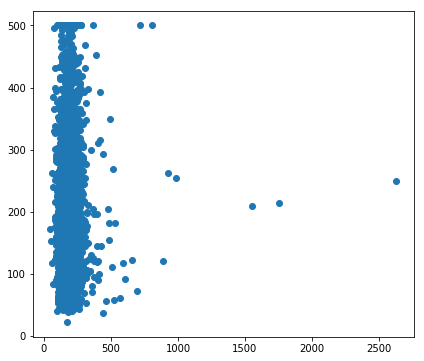

In [15]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.scatter(calibration_data['predictions'],calibration_data['targets'])

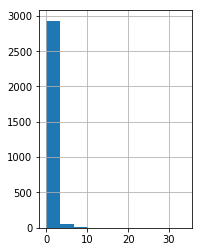

In [16]:
plt.subplot(1,2,2)
_ = california_housing_dataframe['rooms_per_person'].hist()

####  消灭离群值

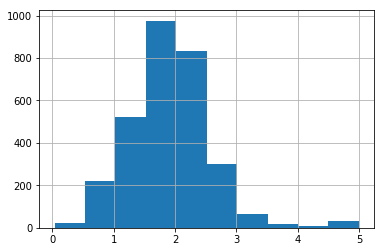

In [19]:
#以5为分割点
california_housing_dataframe['rooms_per_person'] = (
    california_housing_dataframe['rooms_per_person']).apply(lambda x: min(x,5))
_ = california_housing_dataframe['rooms_per_person'].hist()

####  检查有效性

- 再次训练模型并输出统计信息

Training model...
RMSE(on training data):
  period 00 : 210.19
  period 01 : 186.48
  period 02 : 164.16
  period 03 : 143.94
  period 04 : 127.92
  period 05 : 116.75
  period 06 : 110.08
  period 07 : 107.55
  period 08 : 107.08
  period 09 : 106.55
Model training finished


,targets,predictions
count,3000.0,3000.0
mean,205.8,194.6
std,113.1,52.6
min,22.5,48.1
25%,121.2,162.4
50%,177.7,194.1
75%,264.0,222.9
max,500.0,432.2


Final RMSE(on training data):106.55


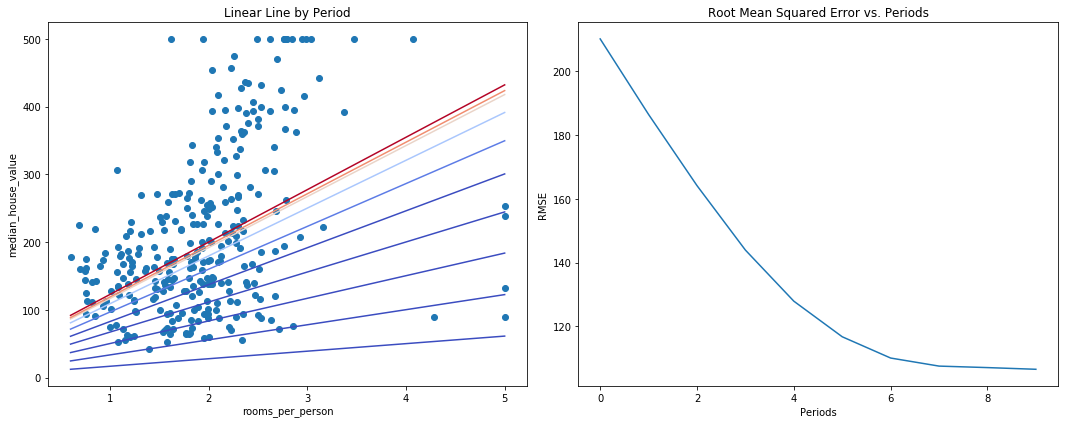

In [20]:
calibration_data = train_model(
    learning_rate = 0.05,
    steps = 500,
    batch_size = 5,
    input_feature = 'rooms_per_person'
)

- 画个散点图检验下

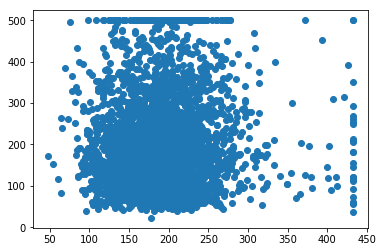

In [21]:
_ = plt.scatter(calibration_data['predictions'],calibration_data['targets'])

> 可以说效果不错